# The Secrets of Statcast I

### MSP, 6.12.2017

Goal: Develop a model for expected number of home runs a pitcher will give up as a function of statcast data.

In [1]:
from IPython.display import HTML
HTML('''<script>code_show=true; function code_toggle() { if (code_show){ $('div.input').hide();} else { $('div.input').show(); } code_show = !code_show} $( document ).ready(code_toggle);</script><form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
# basic imports

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

from exptool.utils import kde_3d

%matplotlib inline

In [3]:

#
# we'll also read in some statcast data for an argument below
#
#    (https://baseballsavant.mlb.com/)

import csv 

def read_statcast_data(infile):
    outdict = np.genfromtxt(\
                            #infile,\
                            ("\t".join(i) for i in csv.reader(open(infile))), delimiter="\t",\
        dtype={'names': ("pitch_type","game_date",\
                         "release_speed","release_pos_x","release_pos_z",\
                         "player_name","batter","pitcher","events","description",
                         "spin_dir","spin_rate_deprecated","break_angle_deprecated",\
                         "break_length_deprecated","zone","des","game_type","stand",\
                         "p_throws","home_team","away_team","type","hit_location",
                         "bb_type","balls","strikes","game_year",\
                         "pfx_x","pfx_z","plate_x","plate_z",\
                         "on_3b","on_2b","on_1b","outs_when_up",\
                         "inning","inning_topbot","hc_x","hc_y",\
                         "tfs_deprecated","tfs_zulu_deprecated","posz_person_id","umpire",\
                         "sv_id","vx0","vy0","vz0",\
                         "ax","ay","az","sz_top","sz_bot",\
                         "hit_distance_sc","launch_speed","launch_angle",\
                         "effective_speed","release_spin_rate","release_extension",\
                         "game_pk",\
                         "pos1_person_id","pos2_person_id","pos3_person_id",
                         "pos4_person_id","pos5_person_id","pos6_person_id",
                         "pos7_person_id","pos8_person_id","pos9_person_id",\
                         "release_pos_y","estimated_ba_using_speedangle",\
                         "estimated_woba_using_speedangle","woba_value",\
                         "woba_denom","babip_value",\
                         "iso_value","launch_speed_angle",\
                         "game_pk2","at_bat_number","pitch_number"),\
                'formats': ('S4','S20',\
                            'f4','f4','f4',\
                            'S20','S20','S20','S20','S20',\
                            'S40','S40','S20',\
                            'S20','S20','S20','S20','S20',\
                            'S20','S20','S20','S20','S20',\
                            'S20','S20','S20','S20',\
                            'S20','S20','S20','S20',\
                            'f4','f4','f4','f4',\
                            'f4','f4','f4','f4',\
                            'f4','f4','f4','f4',\
                            'S20','S20','S20','S20',\
                            'f4','f4','f4','f4',\
                            'f4','f4','f4','f4','f4',\
                            'f4','f4','f4',\
                            'f4','f4','f4',\
                            'S20',\
                            'S20','S20','S20',\
                            'S20','S20','S20',\
                            'S20','S20','S20',\
                            'f4','f4',\
                            'f4','f4',\
                            'f4','f4',\
                            'f4','f4',\
                            'S20','S20','S20')},\
                 skip_header=1)#,delimiter=',')
    return outdict

ESantana   = read_statcast_data('2017Pitching/ESantana061217.csv')
RRay       = read_statcast_data('2017Pitching/RRay061217.csv')
JPaxton    = read_statcast_data('2017Pitching/JPaxton061217.csv')
TRoark     = read_statcast_data('2017Pitching/TRoark061217.csv')
JWeaver    = read_statcast_data('2017Pitching/JWeaver061217.csv')
BPeacock   = read_statcast_data('2017Pitching/BPeacock061217.csv')






HRDist     = read_statcast_data('2017Pitching/HR_ABs061217.csv')
MayMLB     = read_statcast_data('2017Pitching/MayMLB_inplay.csv')



ESantana: 11
RRay: 8
JPaxton: 2
TRoark: 9


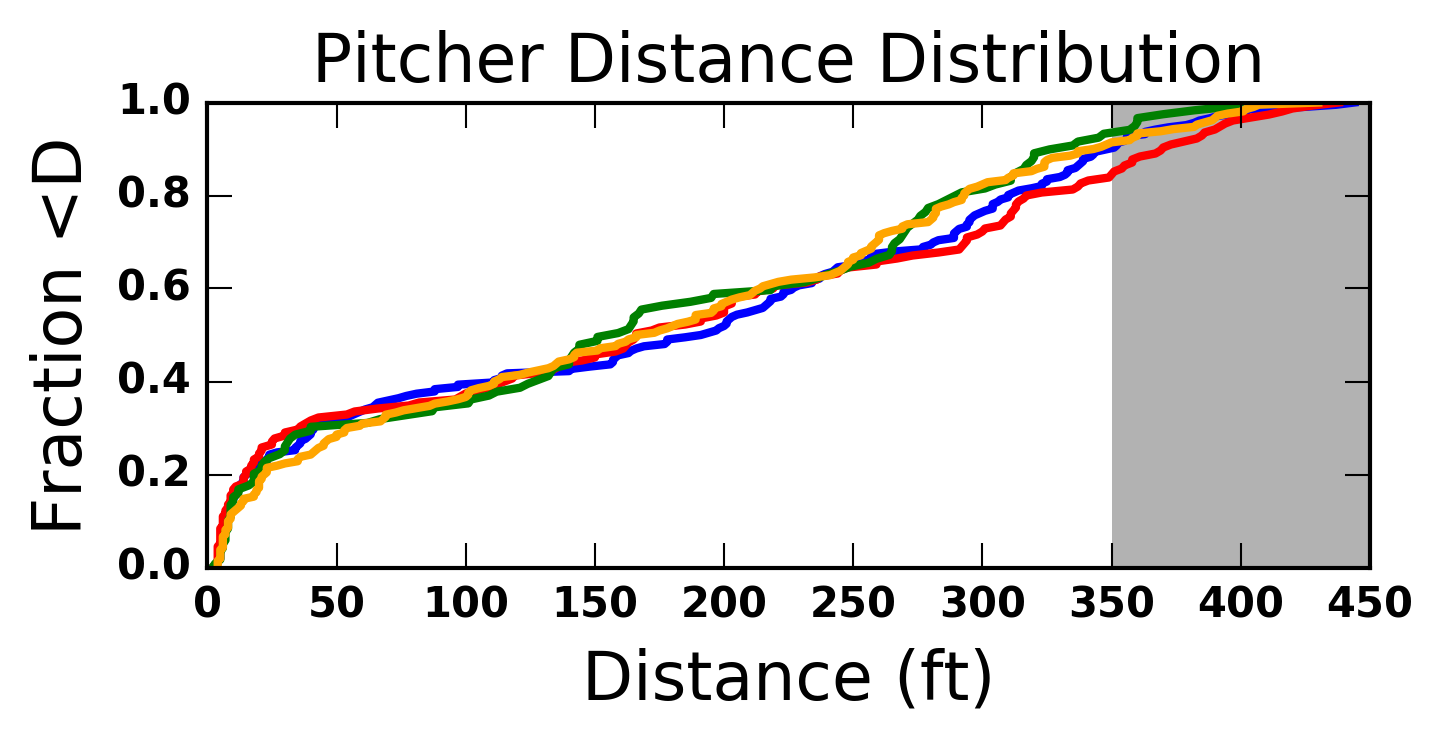

In [23]:
plt.figure(figsize=(5,2))

plt.fill_between([350.,450.],[0.0,0.0],[1.,1.],color='black',alpha=0.3,edgecolor='none')

ESdist = ESantana['hit_distance_sc'][~np.isnan(ESantana['hit_distance_sc'])]
plt.plot(ESdist[ESdist.argsort()],np.linspace(0.,1.,ESdist.size),color='blue')
print 'ESantana:',np.where(ESantana['events']=='home_run')[0].size

RRdist = RRay['hit_distance_sc'][~np.isnan(RRay['hit_distance_sc'])]
plt.plot(RRdist[RRdist.argsort()],np.linspace(0.,1.,RRdist.size),color='red')
print 'RRay:',np.where(RRay['events']=='home_run')[0].size

JPdist = JPaxton['hit_distance_sc'][~np.isnan(JPaxton['hit_distance_sc'])]
plt.plot(JPdist[JPdist.argsort()],np.linspace(0.,1.,JPdist.size),color='green')
print 'JPaxton:',np.where(JPaxton['events']=='home_run')[0].size

TRdist = TRoark['hit_distance_sc'][~np.isnan(TRoark['hit_distance_sc'])]
plt.plot(TRdist[TRdist.argsort()],np.linspace(0.,1.,TRdist.size),color='orange')
print 'TRoark:',np.where(TRoark['events']=='home_run')[0].size


_ = plt.xlabel('Distance (ft)',size=16)
_ = plt.ylabel('Fraction <D',size=16)
_ = plt.title('Pitcher Distance Distribution',size=16)




You know what's amazing? The distribution of HR distances this year.

400 ft is pretty much exactly the 50% mark.

I got started thinking about this because of Aaron Judge's longest (496 ft) recorded HR in the statcast era.

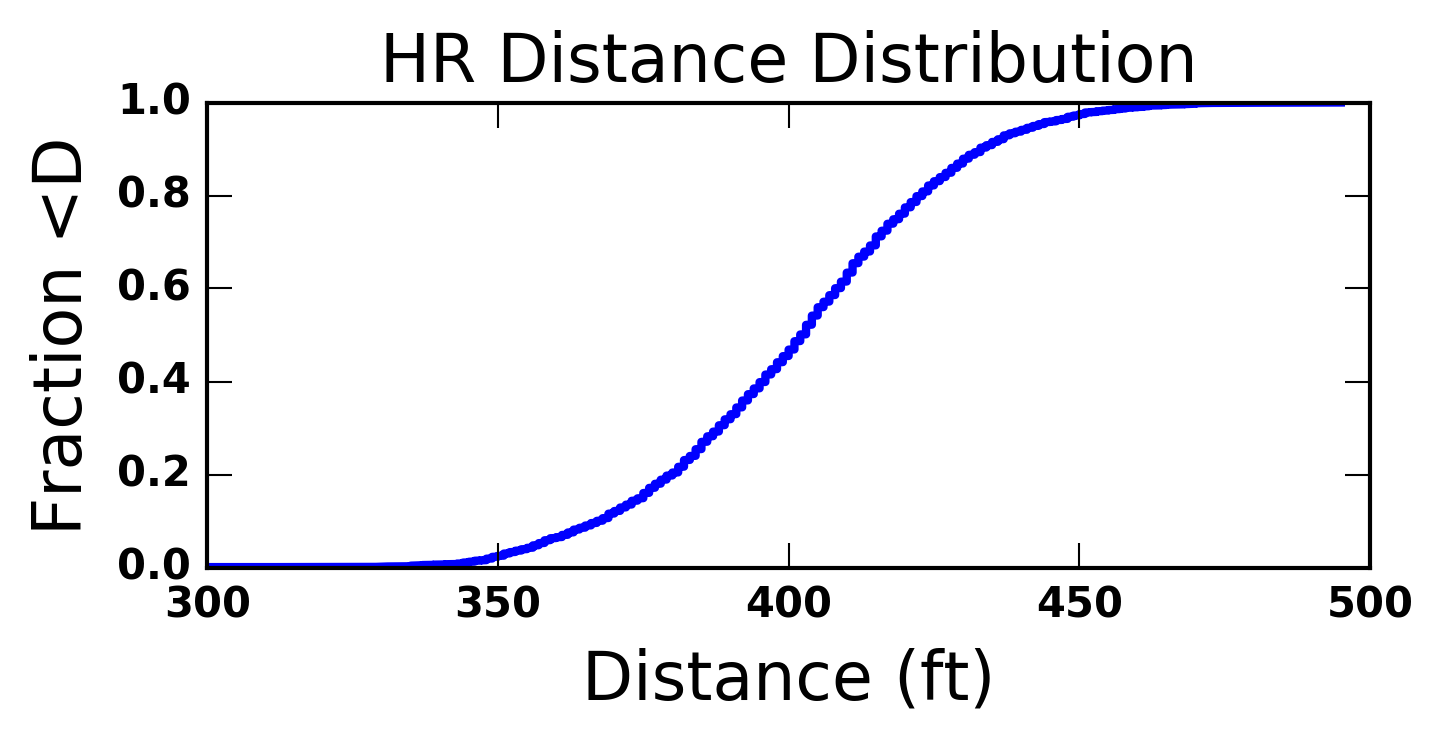

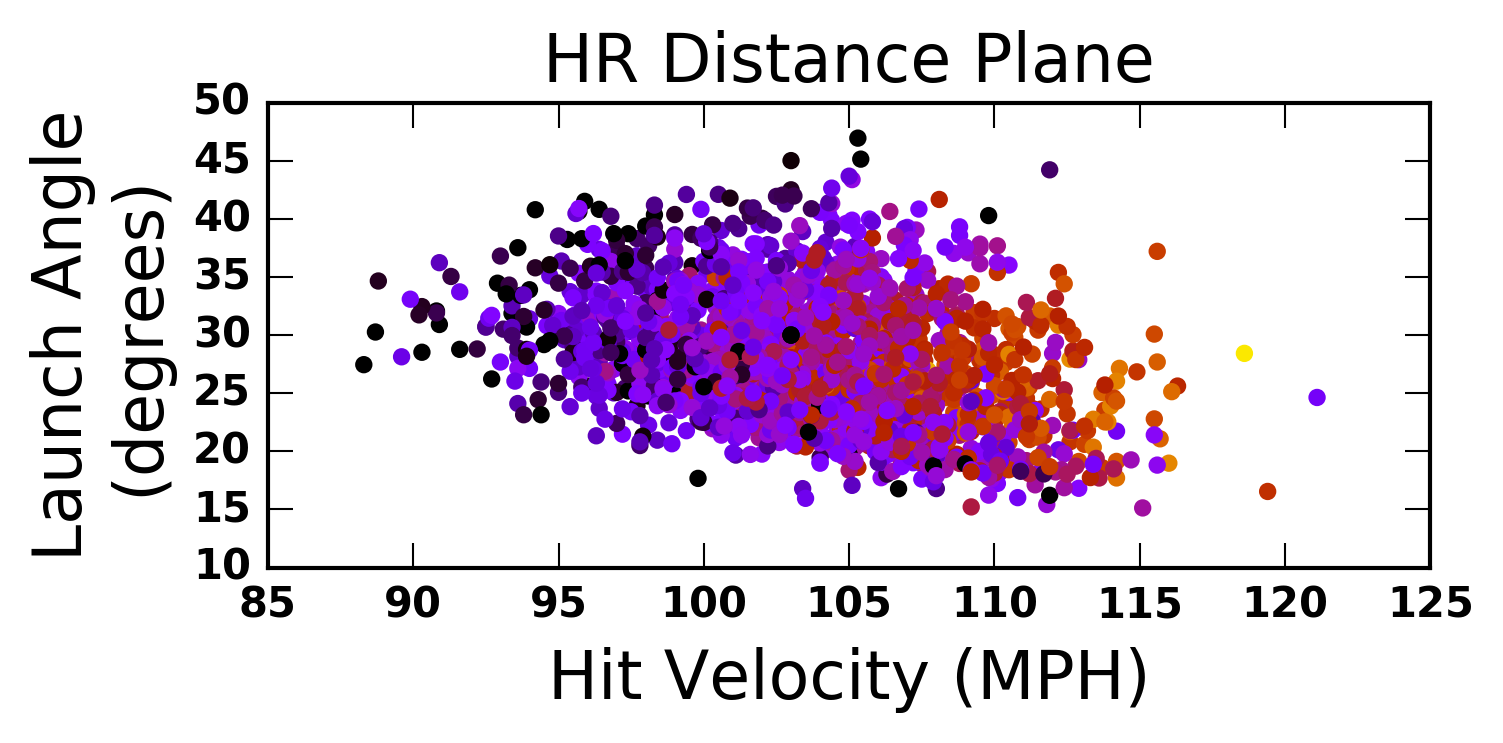

In [19]:

plt.figure(figsize=(5,2))

HRs = HRDist['hit_distance_sc'][~np.isnan(HRDist['hit_distance_sc'])]
plt.plot(HRs[HRs.argsort()],np.linspace(0.,1.,HRs.size),color='blue')

_ = plt.axis([300,500,0.,1.])
_ = plt.xlabel('Distance (ft)',size=16)
_ = plt.ylabel('Fraction <D',size=16)
_ = plt.title('HR Distance Distribution',size=16)



plt.figure(figsize=(5,2))

plt.scatter(HRDist["launch_speed"],HRDist["launch_angle"],color=cm.gnuplot((HRDist["hit_distance_sc"]-350)/150.,1.),s=10)         
_ = plt.xlabel('Hit Velocity (MPH)',size=16)
_ = plt.ylabel('Launch Angle\n(degrees)',size=16)
_ = plt.title('HR Distance Plane',size=16)






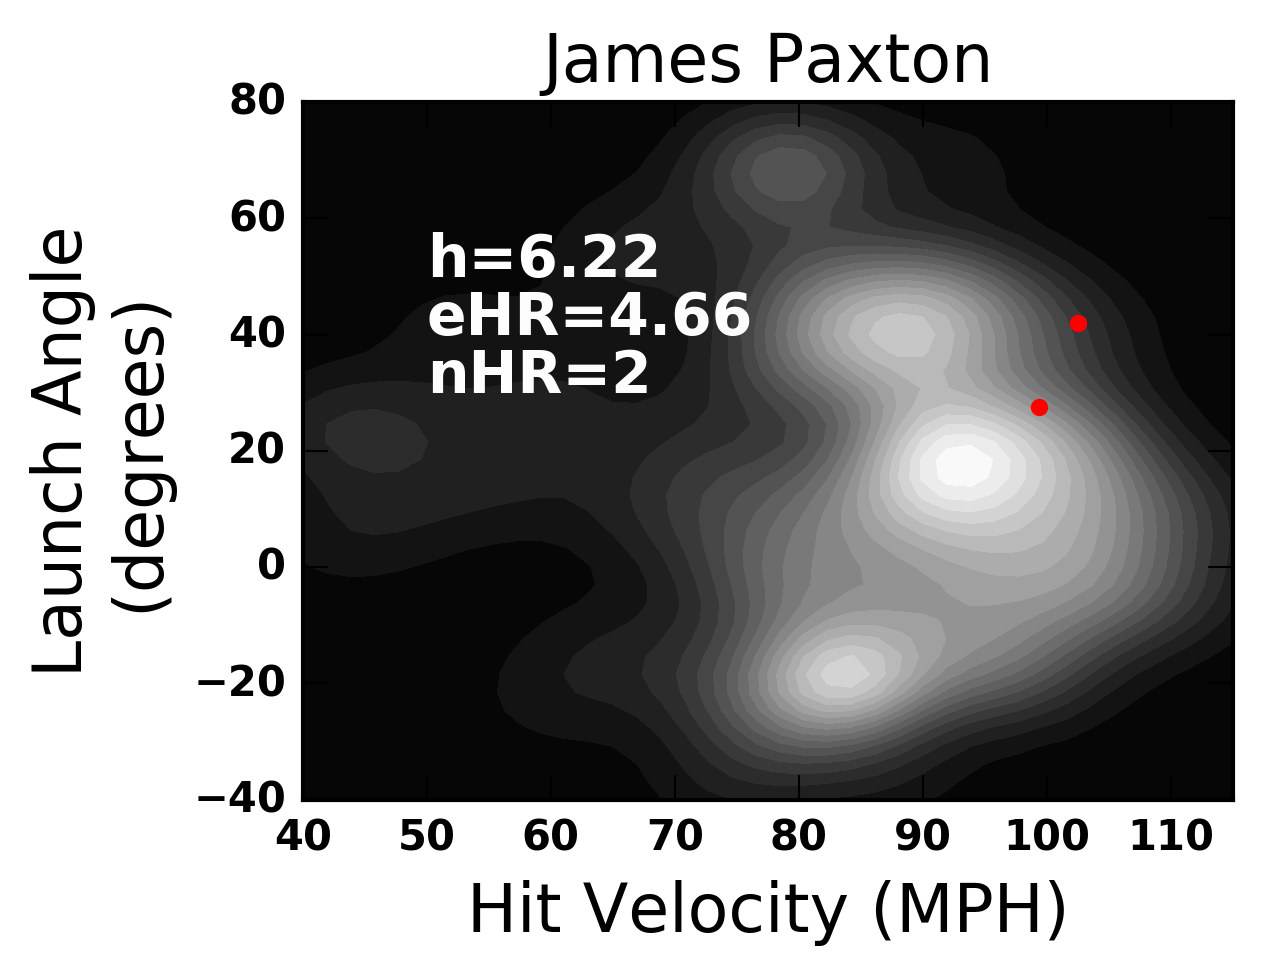

In [32]:


def eHR(plr,plrstr,MLBavg=2.67):

    plt.figure(figsize=(4,3))


    vels = np.linspace(40,115,40)
    angs = np.linspace(-40,80,40)
    tt = kde_3d.fast_kde_two(plr["launch_speed"],plr["launch_angle"], \
                         gridsize=(vels.size,angs.size), extents=(np.min(vels),np.max(vels),np.min(angs),np.max(angs)), \
                         nocorrelation=False)

    vv,aa = np.meshgrid(vels,angs)

    plt.contourf(vels,angs,np.flipud(tt),24,cmap=cm.gray)         

    hrs = np.where(plr['events']=='home_run')[0]
    plt.scatter(plr["launch_speed"][hrs],plr["launch_angle"][hrs],color='red',s=10)
    
    _ = plt.axis([np.min(vels),np.max(vels),np.min(angs),np.max(angs)])
    plt.xlabel('Hit Velocity (MPH)',size=16)
    plt.ylabel('Launch Angle\n(degrees)',size=16)
    plt.title(plrstr,size=16)

    hr_poss = np.where( (vv > 95) & (aa > 20) & (aa < 40))

    HRs = plr['hit_distance_sc'][~np.isnan(plr['hit_distance_sc'])]

    h = np.round((np.sum(tt[hr_poss])/np.sum(tt))/(hrs.size/float(HRs.size)),2)

    plt.text(50,50,'h='+str(h),color='white',size=14)
    plt.text(50,40,'eHR='+str(np.round((np.sum(tt[hr_poss])/np.sum(tt))/(MLBavg/float(HRs.size)),2)),color='white',size=14)
    plt.text(50,30,'nHR='+str(hrs.size),color='white',size=14)



    
eHR(JPaxton,'James Paxton',2.67)



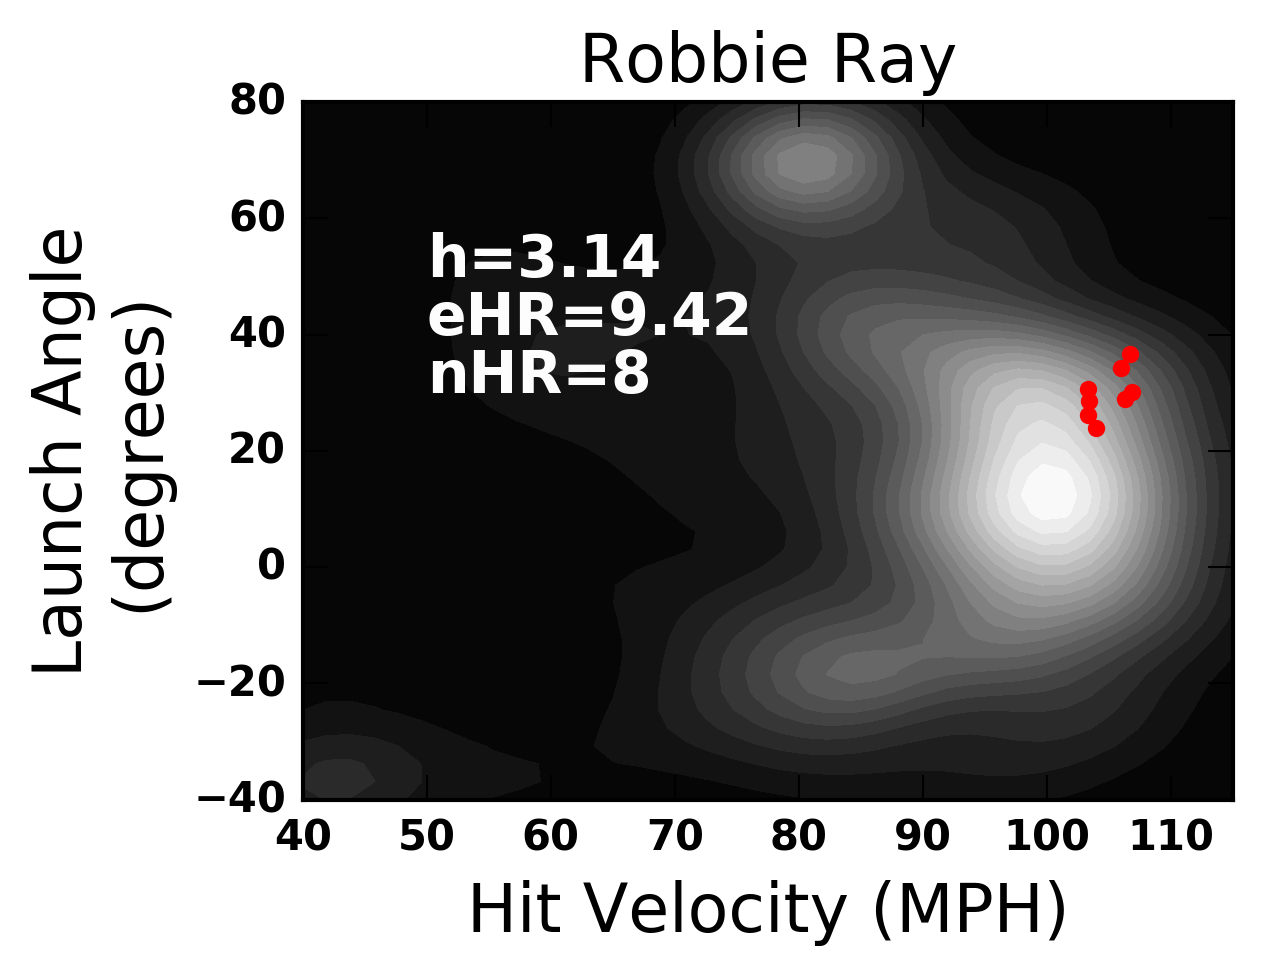

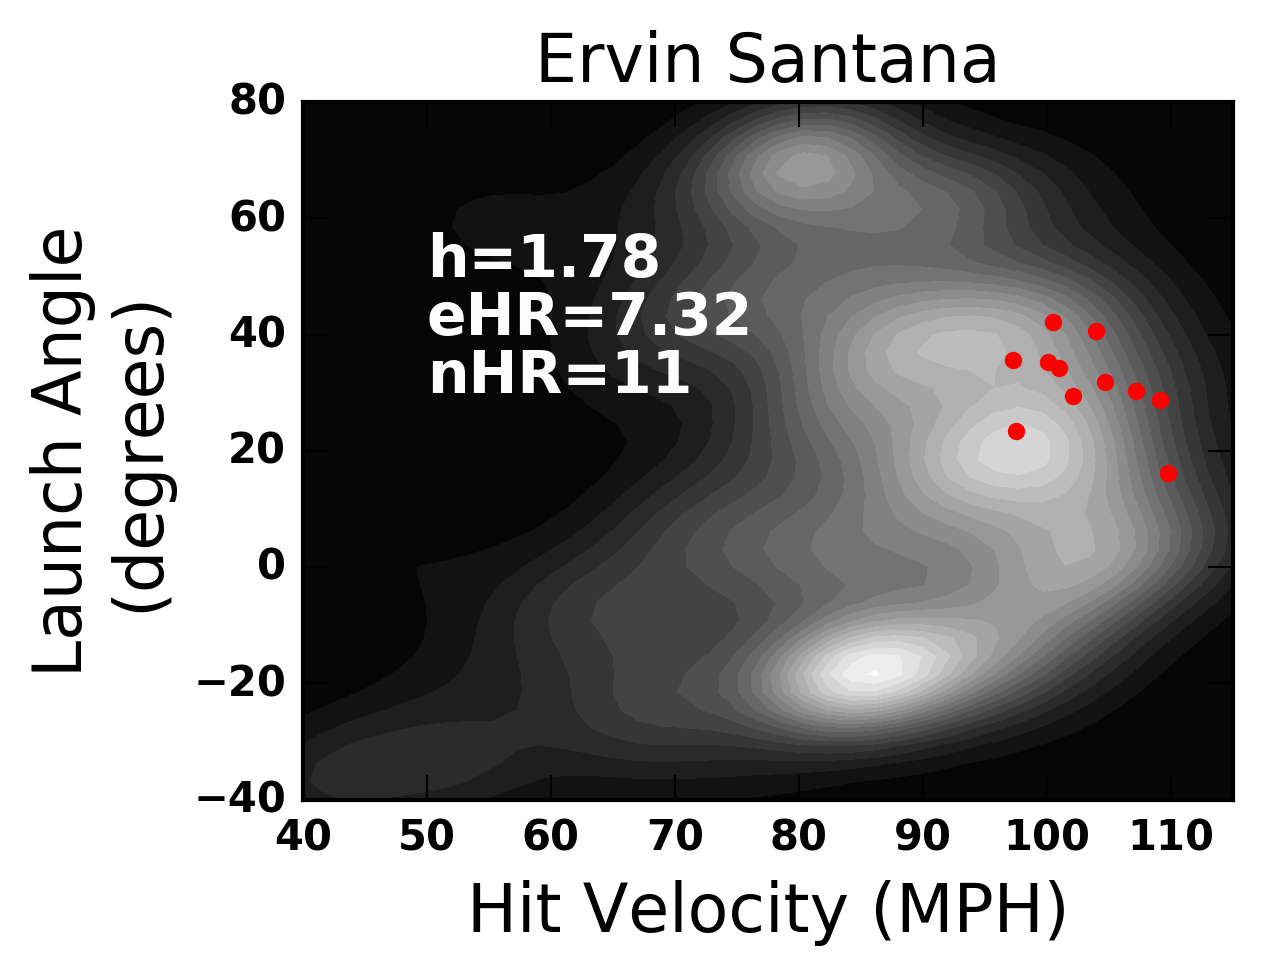

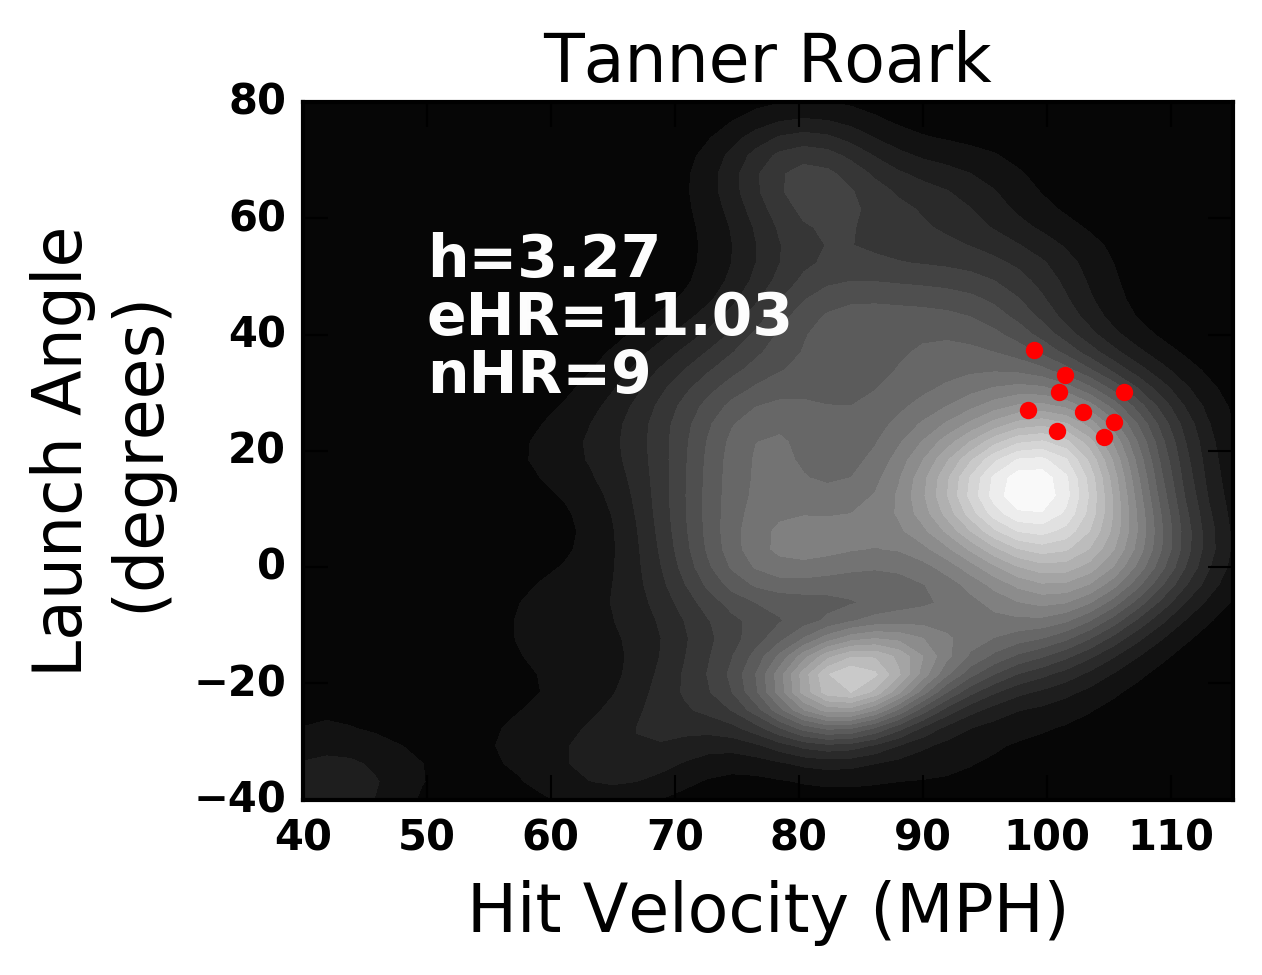

In [33]:
eHR(RRay,'Robbie Ray')
eHR(ESantana,'Ervin Santana')
eHR(TRoark,'Tanner Roark')




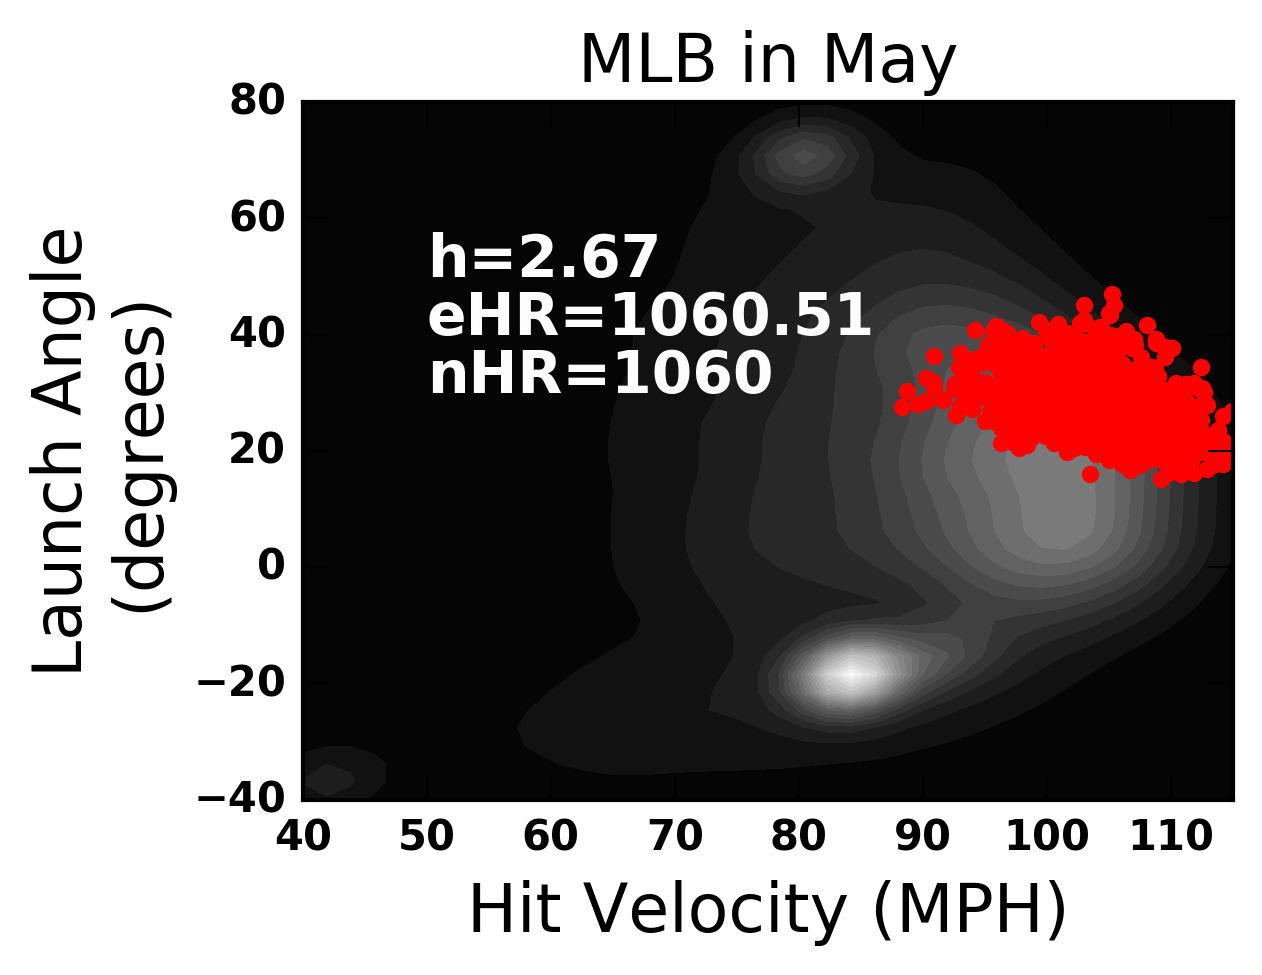

In [34]:
eHR(MayMLB,'MLB in May')

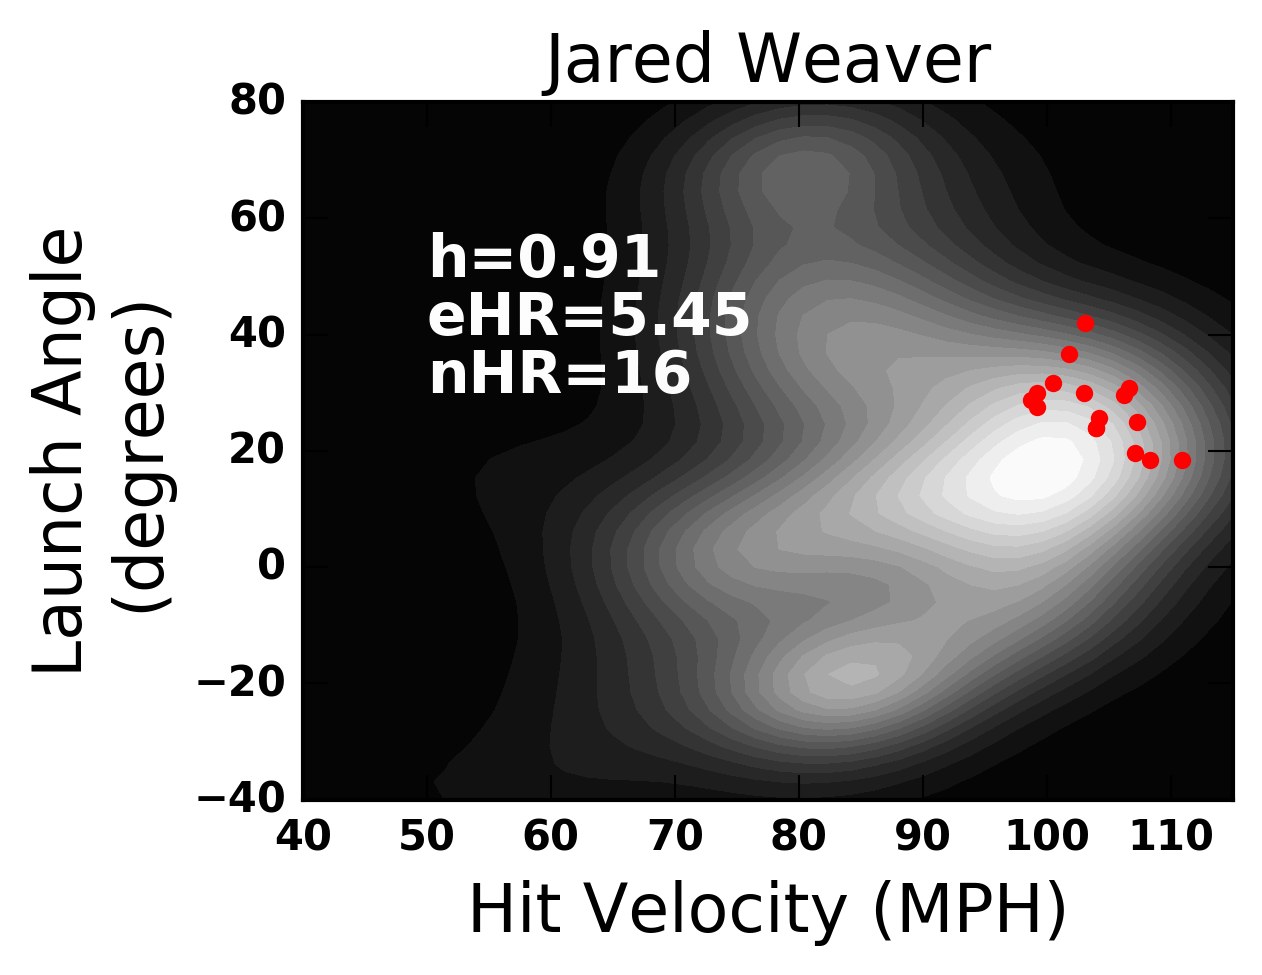

In [35]:
eHR(JWeaver,'Jared Weaver')

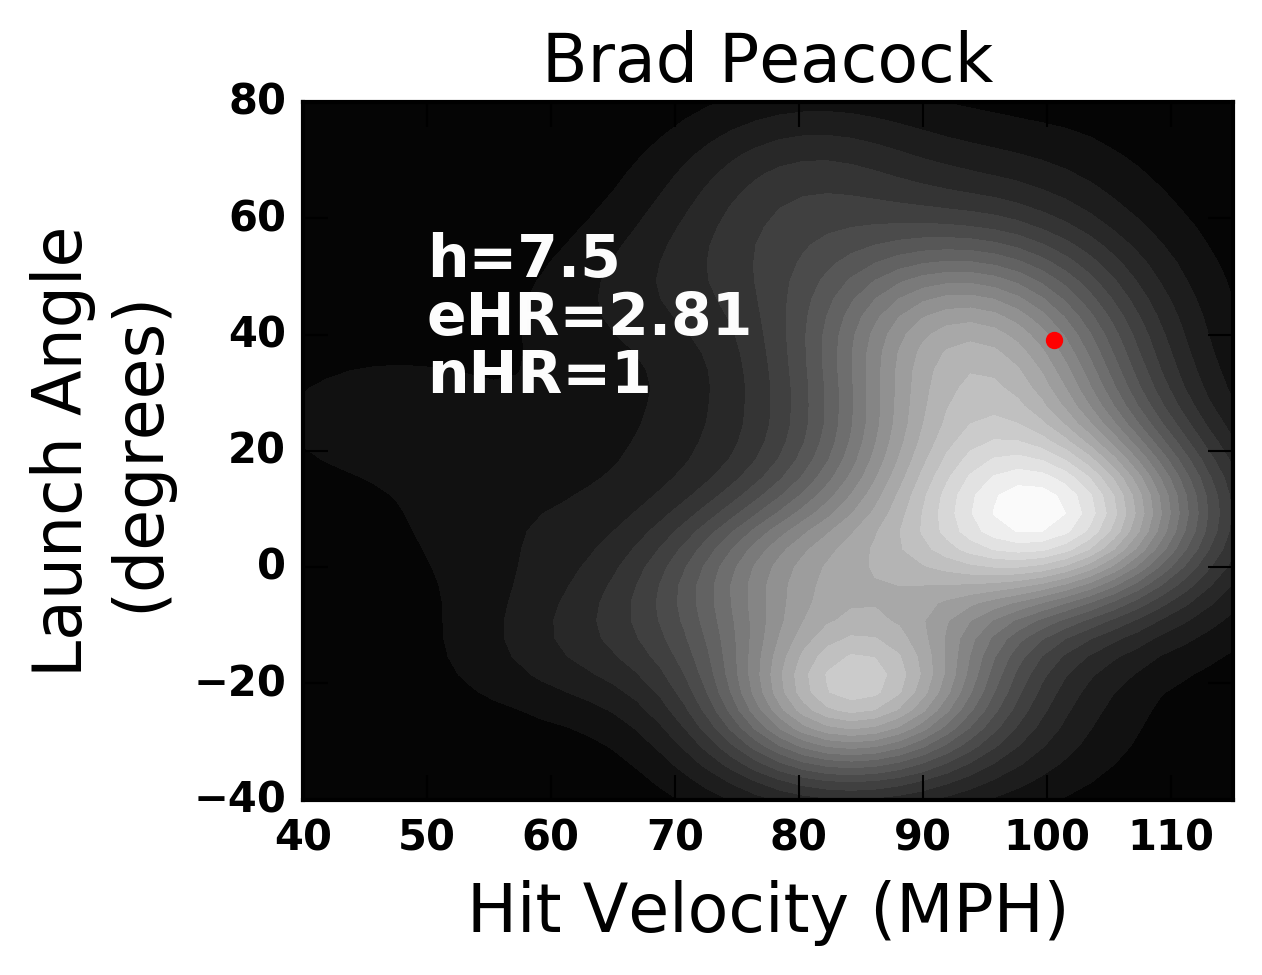

In [36]:
eHR(BPeacock,'Brad Peacock')